# Projection Methods

In [2]:
#This code builds a 3d dataset
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
#Let's look at how PCA, the most popular dimensionality reduction algorithm, works using Single Value Decomposition
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
#We can now find the matrix W2 by isolating the first 2 columns of Vt, allowing us to multiply W2 with the training set X_centered
#which will return a 2d representation of the training set.
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
#Scikit-Learn has a class to use SVD to implement PCA, just like we just did. However, note that the training set does not have to be
#centered beforehand, Scikit-Learn takes care of that for us.
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # 2d
X2D = pca.fit_transform(X)

In [8]:
#We can use Scikit-Learn to obtain the explained variance ratio of each principal component
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [9]:
#This tells us that 84.2% of the dataset's variance lias along the first PC, and 14.6% lies along the second PC.
#This leaves less than 1.2% for the third PC, so it is reasonable to assume that the third PC carries little information.

In [11]:
#When determining how many dimensions to reduce to, you want to stick to a number that adds up to a significantly large percentage
#of the variance (95% or more).  The following code performs PCA without reducing dimensionality, then computes the
#minimum number of dimensions required to preserve 95% of the training set's variance.
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [12]:
#Next you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X)

### PCA for Compression using MNIST dataset

In [13]:
#Obtain the dataset
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [14]:
#Identify a training and a test set
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
#Let's compress the MNIST dataset down to 154 dimensions, then use the inverse transform method to decompress it back to the original 784 dimensions
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Compressed')

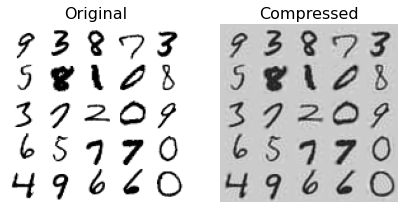

In [16]:
#We can look at the difference between the original images and the compressed versions
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

In [17]:
#Aside from SVD based PCA, there are also Incremental PCA algorithms that were developed to help with large datasets, where
#people could feed the algorithm mini batches of the data. This code shows IPCA at work, using numpy's array_split() method
#to divide the dataset into 100 mini-batches
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

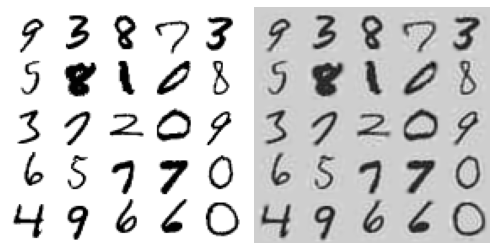

In [18]:
#Let's plot this reduced dataset compared to the original
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [20]:
#Alternatively to using numpy's array_split() method, you can use Numpy's memmap class, which allows you to manipulate a large array stored
#in a binary file on disk as if it were entirely in memory; the class only loads the data it needs in memory, when it needs it
filename = "datasets/my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

del X_mm

X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

# Kernel PCA

In [21]:
#Kernel PCA can be used to perform complex nonlinear projections for dimensionality reduction. Here we create a swiss roll dataset to test on
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [22]:
#We can use Scikit-Learn's KernelPCA class to perform Kernel PCA
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

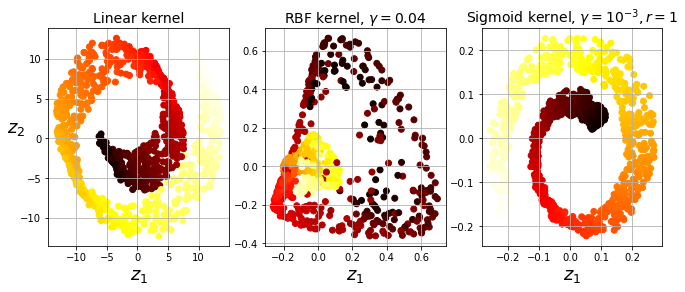

In [23]:
#Here we show the swiss roll, reduced to 2 dimensions using a linear kernel, a RBF kernel, and a sigmoid kernel
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [25]:
#The following code creates a 2-step pipeline, first reducing dimensionality to two dimensions using kPCA, then applying
#Logistic Regression for classification. Then it uses GridSearchCV to find the best kernel and gamma values for kPCA in
#order to get the best classification accuracy at the end of the pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [26]:
#Let's print the best hyperparameters
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [27]:
#Here we will use a method that isolates the kernel and hyperparameters that yields the lowest reconstruction error on the dataset
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [28]:
#We can now compute the reconstruction pre-image error
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

7.18982137984582e-27

In [29]:
#You can now use grid search with cross-validation to find the kernel and hyperparameters that minimize this error

# LLE

In [30]:
#This nonlinear dimensionality reduction technique is particularly good at unrolling twisted manifolds. Let's see it unroll the swiss roll
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

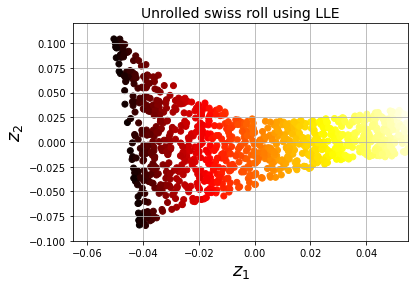

In [31]:
#Let's plot the new shape it returns
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

# Other Dimensionality Reduction Techniques

In [32]:
#Here is Multidimensional Scaling, which reduces dimensionality while trying to preserve the distances between instances
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [34]:
#Here is Isomap, which creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to 
#preserve the geodesic distances between instances
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [35]:
#Here is t-SNE, which tries to keep similar instances close and dissimilar instances apart. Typically used for visualization, in particular to visualize
#clusters of instances in high dimensional space
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

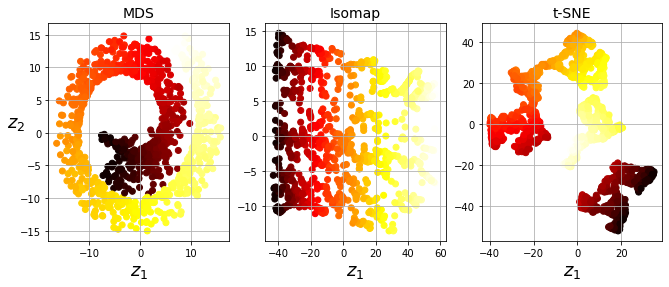

In [37]:
#Here we will show the results of the three techniques discussed above, but there are many more beyond those mentioned in this notebook
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# That's it for dimensionality reduction!